<a href="https://colab.research.google.com/github/hamedebrahimi68/financial_markets_predictoin/blob/master/v1_randomforrest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching Bitcoin data...
Training Random Forest model...
Mean Squared Error: 0.006557920337861133
Mean Absolute Error: 0.031178641230443196

=== Prediction Summary ===
Current Price: $92204.40
Current Time: 2024-11-27 00:35:20.664312

Prediction for 2 Hours:
Price: $72673.78
Percent Change: -21.18%
Absolute Change: $-19530.62

Prediction for 6 Hours:
Price: $72529.83
Percent Change: -21.34%
Absolute Change: $-19674.56

Prediction for 12 Hours:
Price: $72434.53
Percent Change: -21.44%
Absolute Change: $-19769.86

Prediction for 24 Hours:
Price: $72458.35
Percent Change: -21.42%
Absolute Change: $-19746.04

Prediction for 48 Hours:
Price: $72503.48
Percent Change: -21.37%
Absolute Change: $-19700.92

Prediction for 72 Hours:
Price: $72503.48
Percent Change: -21.37%
Absolute Change: $-19700.92

Prediction for 1 Week:
Price: $72494.83
Percent Change: -21.38%
Absolute Change: $-19709.57

Prediction for 1 Month:
Price: $72494.83
Percent Change: -21.38%
Absolute Change: $-19709.57


<ipython-input-2-d3b613310551>:85: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(


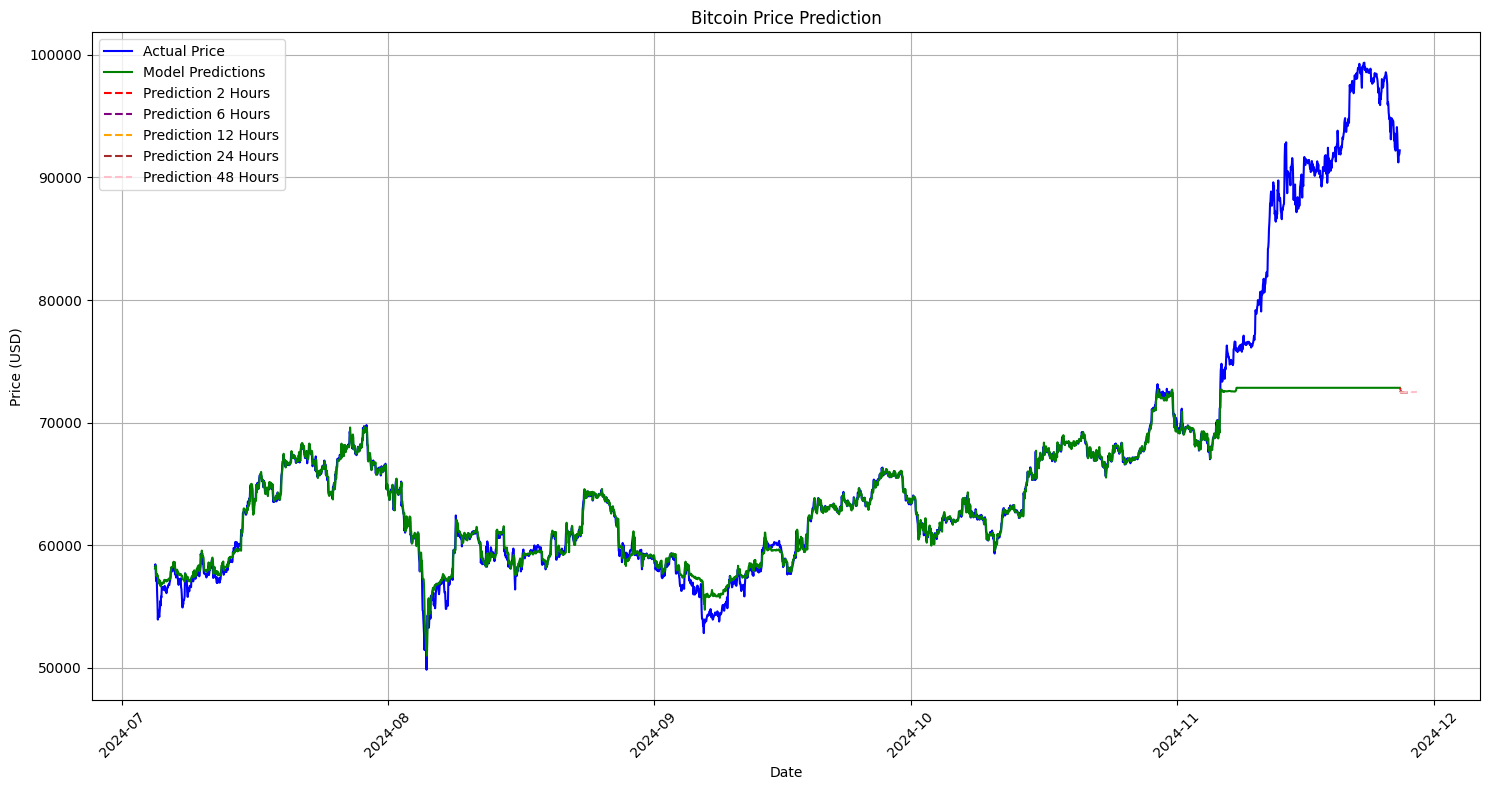

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta

def get_bitcoin_data():
    """Fetch Bitcoin hourly data for the last 2 years"""
    btc = yf.Ticker("BTC-USD")
    data = btc.history(period="2y", interval="1h")
    return data['Close']

def prepare_data(data, time_steps=48):
    """Prepare data for time series prediction"""
    # Create features and target
    X, y = [], []
    scaled_data = MinMaxScaler().fit_transform(data.values.reshape(-1, 1)).flatten()

    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
        y.append(scaled_data[i+time_steps])

    X, y = np.array(X), np.array(y)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test

def create_random_forest_model():
    """Create Random Forest Regressor model"""
    return RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

def predict_multiple_horizons(model, last_sequence, scaler, horizons):
    """Predict prices for multiple time horizons"""
    predictions = {}
    current_sequence = last_sequence.copy()

    for horizon in horizons:
        horizon_predictions = []
        for _ in range(horizon):
            # Predict next time step
            next_pred_scaled = model.predict(current_sequence.reshape(1, -1))[0]
            horizon_predictions.append(next_pred_scaled)

            # Update sequence by shifting and adding new prediction
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[-1] = next_pred_scaled

        # Inverse transform predictions
        predictions[horizon] = scaler.inverse_transform(
            np.array(horizon_predictions).reshape(-1, 1)
        )

    return predictions

def plot_predictions(bitcoin_data, predictions, X_test, y_test, model_predictions):
    """Plot actual vs predicted prices and future predictions"""
    plt.figure(figsize=(15, 8))

    # Plot actual test data
    test_start_index = len(bitcoin_data) - len(y_test)
    plt.plot(bitcoin_data.index[test_start_index:], bitcoin_data.values[-len(y_test):],
             label='Actual Price', color='blue')

    # Plot model predictions for test set
    plt.plot(bitcoin_data.index[test_start_index:], model_predictions,
             label='Model Predictions', color='green')

    # Colors for different prediction horizons
    colors = ['red', 'purple', 'orange', 'brown', 'pink']

    # Plot future predictions for different horizons
    for (horizon, pred), color in zip(predictions.items(), colors):
        future_dates = pd.date_range(
            start=bitcoin_data.index[-1],
            periods=len(pred)+1,
            freq='H'
        )[1:]
        plt.plot(future_dates, pred,
                 label=f'Prediction {horizon} Hours',
                 color=color, linestyle='--')

    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    """Main function to execute the Bitcoin price prediction workflow."""
    # Get Bitcoin data
    print("Fetching Bitcoin data...")
    bitcoin_data = get_bitcoin_data()

    # Prepare data
    TIME_STEPS = 48  # Number of hours to look back for prediction
    X_train, X_test, y_train, y_test = prepare_data(bitcoin_data, TIME_STEPS)

    # Create and train the Random Forest model
    print("Training Random Forest model...")
    model = create_random_forest_model()
    model.fit(X_train, y_train)

    # Create a MinMaxScaler instance and fit it to the data
    scaler = MinMaxScaler()
    scaler.fit(bitcoin_data.values.reshape(-1, 1))

    # Predict on test set and inverse transform to original scale
    test_predictions_scaled = model.predict(X_test)
    test_predictions_original_scale = scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, test_predictions_scaled)
    mae = mean_absolute_error(y_test, test_predictions_scaled)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    # Predict for multiple time horizons
    horizons = [2, 6, 12, 24, 48, 72, 168, 720]  # Prediction horizons in hours
    last_sequence = X_test[-1]
    predictions = predict_multiple_horizons(model, last_sequence, scaler, horizons)

    # Print predictions summary
    current_price = bitcoin_data.iloc[-1]
    print("\n=== Prediction Summary ===")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Current Time: {datetime.now()}")

    for horizon, pred in predictions.items():
        final_price = pred[-1][0]
        change_percent = ((final_price - current_price) / current_price) * 100
        time_description = (
            "1 Month" if horizon == 720 else
            "1 Week" if horizon == 168 else
            f"{horizon} Hours"
        )
        print(f"\nPrediction for {time_description}:")
        print(f"Price: ${final_price:.2f}")
        print(f"Percent Change: {change_percent:.2f}%")
        print(f"Absolute Change: ${(final_price - current_price):.2f}")

    # Plot results
    plot_predictions(bitcoin_data, predictions, X_test, y_test, test_predictions_original_scale)

if __name__ == "__main__":
    main()